# Space Invader with Poximal Policy Optimization

## Step 1: Import the libraries

In [1]:
# !pip install gym[atari]
# !pip install gym[accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 9.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=baa7738cf73f81bd1f288a0822edb1c8c6f7a925a12fa1c72b45faa1003300c2
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license


In [2]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import random

class PPOAgent():
    def __init__(self, input_shape, action_size, seed, device, gamma, alpha, beta, tau, update_every, batch_size, ppo_epoch, clip_param, actor_m, critic_m):
        """Initialize an Agent object.
        Params
        ======
            input_shape (tuple): dimension of each state (C, H, W)
            action_size (int): dimension of each action
            seed (int): random seed
            device(string): Use Gpu or CPU
            gamma (float): discount factor
            alpha (float): Actor learning rate
            beta (float): Critic learning rate 
            tau (float): Tau Value
            update_every: How often to update network
            batch_size (int): Mini Batch size to be used every epoch 
            ppo_epoch(int): Total No epoch for ppo
            clip_param(float): Clip Paramter
            actor_m(Model): Pytorch Actor Model
            critic_m(Model): PyTorch Critic Model
        """
        self.input_shape = input_shape
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.tau = tau
        self.update_every = update_every
        self.batch_size = batch_size
        self.ppo_epoch = ppo_epoch
        self.clip_param = clip_param

        # Actor-Network
        self.actor_net = actor_m(input_shape, action_size).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=self.alpha)

        # Critic-Network
        self.critic_net = critic_m(input_shape).to(self.device)
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), lr=self.beta)

        # Memory
        self.log_probs = []
        self.values    = []
        self.states    = []
        self.actions   = []
        self.rewards   = []
        self.masks     = []
        self.entropies = []

        self.t_step = 0

    def step(self, state, action, value, log_prob, reward, done, next_state):
        
        # Save experience in  memory
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.states.append(torch.from_numpy(state).unsqueeze(0).to(self.device))
        self.rewards.append(torch.from_numpy(np.array([reward])).to(self.device))
        self.actions.append(torch.from_numpy(np.array([action])).to(self.device))
        self.masks.append(torch.from_numpy(np.array([1 - done])).to(self.device))

        self.t_step = (self.t_step + 1) % self.update_every

        if self.t_step == 0:
           self.learn(next_state)
           self.reset_memory()
                
    def act(self, state):
        """Returns action, log_prob, value for given state as per current policy."""
        
        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        action_probs = self.actor_net(state)
        value = self.critic_net(state)

        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)

        return action.item(), log_prob, value
        
    def learn(self, next_state):
        next_state = torch.from_numpy(next_state).unsqueeze(0).to(self.device)
        next_value = self.critic_net(next_state)

        returns        = torch.cat(self.compute_gae(next_value)).detach()
        self.log_probs = torch.cat(self.log_probs).detach()
        self.values    = torch.cat(self.values).detach()
        self.states    = torch.cat(self.states)
        self.actions   = torch.cat(self.actions)
        advantages     = returns - self.values

        for _ in range(self.ppo_epoch):
            for state, action, old_log_probs, return_, advantage in self.ppo_iter(returns, advantages):

                dist = self.actor_net(state)
                value = self.critic_net(state)

                entropy = dist.entropy().mean()
                new_log_probs = dist.log_prob(action)

                ratio = (new_log_probs - old_log_probs).exp()
                surr1 = ratio * advantage
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * advantage

                actor_loss  = - torch.min(surr1, surr2).mean()
                critic_loss = (return_ - value).pow(2).mean()
                
                loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

                # Minimize the loss
                self.actor_optimizer.zero_grad()
                self.critic_optimizer.zero_grad()
                loss.backward()
                self.actor_optimizer.step()
                self.critic_optimizer.step()

        self.reset_memory()

    
    def ppo_iter(self, returns, advantage):
        memory_size = self.states.size(0)
        for _ in range(memory_size // self.batch_size):
            rand_ids = np.random.randint(0, memory_size, self.batch_size)
            yield self.states[rand_ids, :], self.actions[rand_ids], self.log_probs[rand_ids], returns[rand_ids, :], advantage[rand_ids, :]

    def reset_memory(self):
        self.log_probs = []
        self.values    = []
        self.states    = []
        self.actions   = []
        self.rewards   = []
        self.masks     = []
        self.entropies = []

    def compute_gae(self, next_value):
        gae = 0
        returns = []
        values = self.values + [next_value]
        for step in reversed(range(len(self.rewards))):
            delta = self.rewards[step] + self.gamma * values[step + 1] * self.masks[step] - values[step]
            gae = delta + self.gamma * self.tau * self.masks[step] * gae
            returns.insert(0, gae + values[step])
        return returns

In [5]:
import sys
sys.path.append('../../')
# from tf_agents.models import ActorCnn, CriticCnn
# from algos.preprocessing.stack_frame import preprocess_frame, stack_frame

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [6]:
env = gym.make('SpaceInvaders-v0')
env.seed(0)

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment SpaceInvaders-v0 is out of date. You should consider upgrading to version `v4`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in

(2968811710, 3677149159)

In [7]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


## Step 3: Viewing our Enviroment

The size of frame is:  (210, 160, 3)
No. of Actions:  6


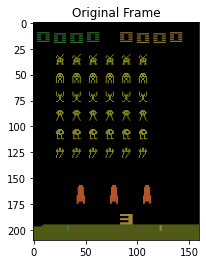

In [8]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

### Execute the code cell below to play Pong with a random policy.

In [9]:
def random_play():
    score = 0
    env.reset()
    while True:
        env.render(mode='rgb_array')
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:298: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  "No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps."
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:228: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  "Core environment is written in old step API which r

Your Score at end of game is:  115.0


In [10]:
import numpy as np
import cv2

def preprocess_frame(screen, exclude, output):
    """Preprocess Image.
        
        Params
        ======
            screen (array): RGB Image
            exclude (tuple): Section to be croped (UP, RIGHT, DOWN, LEFT)
            output (int): Size of output image
        """
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    
    #Crop screen[Up: Down, Left: right] 
    screen = screen[exclude[0]:exclude[2], exclude[3]:exclude[1]]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    screen = cv2.resize(screen, (output, output), interpolation = cv2.INTER_AREA)
    return screen

def stack_frame(stacked_frames, frame, is_new):
    """Stacking Frames.
        
        Params
        ======
            stacked_frames (array): Four Channel Stacked Frame
            frame: Preprocessed Frame to be added
            is_new: Is the state First
        """
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

## Step 4:Preprocessing Frame

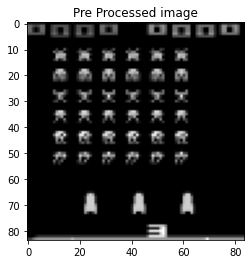

In [11]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [12]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

In [13]:
import torch
import torch.nn as nn
import torch.autograd as autograd 
import torch.nn.functional as F
from torch.distributions import Categorical

class ActorCnn(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(ActorCnn, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        dist = Categorical(x)
        return dist
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

class CriticCnn(nn.Module):
    def __init__(self, input_shape):
        super(CriticCnn, self).__init__()
        self.input_shape = input_shape
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

## Step 6: Creating our Agent

In [42]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
ALPHA= 0.0001          # Actor learning rate
BETA = 0.0001          # Critic learning rate
TAU = 0.95
BATCH_SIZE = 32
PPO_EPOCH = 5
CLIP_PARAM = 0.2
UPDATE_EVERY = 1000     # how often to update the network 

with open('agent_ppo_2000.pkl', 'rb') as inp:
    agent = pickle.load(inp)
# agent = PPOAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, TAU, UPDATE_EVERY, BATCH_SIZE, PPO_EPOCH, CLIP_PARAM, ActorCnn, CriticCnn)

## Step 7: Watching untrained agent play

In [43]:

# watch an untrained agent
state = stack_frames(None, env.reset(), True) 
for j in range(200):
    env.render(mode='rgb_array')
    action, _, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = stack_frames(state, next_state, False)
    if done:
        break 
        
env.close()

## Step 8: Loading Agent
Uncomment line to load a pretrained agent

In [44]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

## Step 9: Train the Agent with DQN

In [45]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        while True:
            action, log_prob, value = agent.act(state)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, value, log_prob, reward, done, next_state)
            if done:
                break
            else:
                state = next_state
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    
    return scores

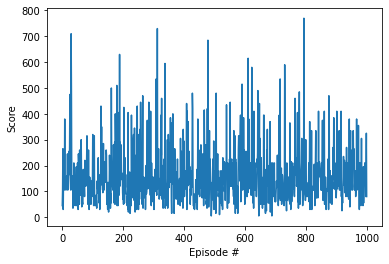

Episode 1000	Average Score: 141.50

In [46]:
scores = train(1000)

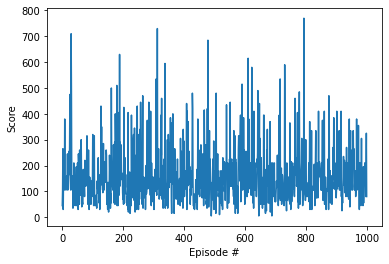

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Step 10: Watch a Smart Agent!

In [49]:
score = 0
state = stack_frames(None, env.reset(), True)
while True:
    env.render(mode='rgb_array')
    action, _, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()

/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


You Final score is: 210.0


In [51]:
import pickle
with open('agent_ppo_3000.pkl', 'wb') as outp:
    pickle.dump(agent, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('agent_ppo_1000.pkl', 'rb') as inp:
#     agent1 = pickle.load(inp)


EOFError: ignored

# **Video snimak jedne epizode**

In [76]:
import cv2
# import os
from PIL import Image

score = 0
video_name = 'video2.avi'

height, width, frames_per_second = 210,160,10

# video = cv2.VideoWriter(video_name, 0, 1, (width,height))
video_writer = cv2.VideoWriter('video.mp4', fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=float(frames_per_second), frameSize=(width, height), isColor=True)
images = []
state = stack_frames(None, env.reset(), True)
while True:
    action, _, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    images.append(next_state)
    # image = Image.fromarray(next_state)
    frame = cv2.cvtColor(next_state, cv2.COLOR_RGB2BGR)
    video_writer.write(frame)
    if done:
        print("Score is:", score)
        break 
env.close()
cv2.destroyAllWindows()
video_writer.release()


Score is: 305.0


# **Testiranje na 30 epizoda**

In [81]:
import tqdm
test_scores = []
BROJ_EPIZODA =30
for i in tqdm.tqdm(range(BROJ_EPIZODA)):
    state = stack_frames(None, env.reset(), True)
    done = False
    score = 0
    while not done:
        action, _, _ = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        score += reward
        state = stack_frames(state, next_state, False)
        if done:
            print("You Final score is:", score)
            break 
    test_scores.append(score)
    print(f"score{score}")

  3%|▎         | 1/30 [00:01<00:34,  1.18s/it]

You Final score is: 80.0
score80.0


  7%|▋         | 2/30 [00:02<00:35,  1.27s/it]

You Final score is: 105.0
score105.0


 10%|█         | 3/30 [00:04<00:37,  1.40s/it]

You Final score is: 45.0
score45.0


 13%|█▎        | 4/30 [00:06<00:44,  1.70s/it]

You Final score is: 210.0
score210.0


 17%|█▋        | 5/30 [00:08<00:45,  1.81s/it]

You Final score is: 410.0
score410.0


 20%|██        | 6/30 [00:09<00:39,  1.64s/it]

You Final score is: 65.0
score65.0


 23%|██▎       | 7/30 [00:10<00:33,  1.45s/it]

You Final score is: 40.0
score40.0


 27%|██▋       | 8/30 [00:12<00:33,  1.54s/it]

You Final score is: 110.0
score110.0


 30%|███       | 9/30 [00:14<00:34,  1.63s/it]

You Final score is: 150.0
score150.0


 33%|███▎      | 10/30 [00:15<00:33,  1.69s/it]

You Final score is: 180.0
score180.0


 37%|███▋      | 11/30 [00:19<00:41,  2.17s/it]

You Final score is: 320.0
score320.0


 40%|████      | 12/30 [00:20<00:36,  2.00s/it]

You Final score is: 130.0
score130.0


 43%|████▎     | 13/30 [00:22<00:29,  1.75s/it]

You Final score is: 125.0
score125.0


 47%|████▋     | 14/30 [00:23<00:25,  1.57s/it]

You Final score is: 65.0
score65.0


 50%|█████     | 15/30 [00:25<00:28,  1.92s/it]

You Final score is: 390.0
score390.0


 53%|█████▎    | 16/30 [00:26<00:22,  1.60s/it]

You Final score is: 40.0
score40.0


 57%|█████▋    | 17/30 [00:28<00:21,  1.67s/it]

You Final score is: 105.0
score105.0


 60%|██████    | 18/30 [00:29<00:17,  1.45s/it]

You Final score is: 10.0
score10.0


 63%|██████▎   | 19/30 [00:31<00:17,  1.58s/it]

You Final score is: 180.0
score180.0


 67%|██████▋   | 20/30 [00:35<00:21,  2.20s/it]

You Final score is: 515.0
score515.0


 70%|███████   | 21/30 [00:36<00:17,  1.98s/it]

You Final score is: 45.0
score45.0


 73%|███████▎  | 22/30 [00:38<00:15,  1.88s/it]

You Final score is: 155.0
score155.0


 77%|███████▋  | 23/30 [00:40<00:13,  1.91s/it]

You Final score is: 160.0
score160.0


 80%|████████  | 24/30 [00:42<00:11,  1.96s/it]

You Final score is: 110.0
score110.0


 83%|████████▎ | 25/30 [00:43<00:09,  1.82s/it]

You Final score is: 120.0
score120.0


 87%|████████▋ | 26/30 [00:45<00:07,  1.83s/it]

You Final score is: 125.0
score125.0


 90%|█████████ | 27/30 [00:47<00:05,  1.92s/it]

You Final score is: 245.0
score245.0


 93%|█████████▎| 28/30 [00:49<00:03,  1.96s/it]

You Final score is: 135.0
score135.0


 97%|█████████▋| 29/30 [00:51<00:01,  1.83s/it]

You Final score is: 105.0
score105.0


100%|██████████| 30/30 [00:53<00:00,  1.77s/it]

You Final score is: 210.0
score210.0


count     30.000000
mean     156.166667
std      117.676378
min       10.000000
25%       86.250000
50%      125.000000
75%      180.000000
max      515.000000
dtype: float64


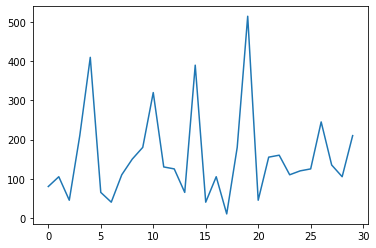

In [84]:
import pandas as pd
s_test = pd.Series(test_scores)
print(s_test.describe())
plt.plot(range(BROJ_EPIZODA), s_test)

In [85]:
from google.colab import files
import pandas as pd
s = pd.Series(test_scores)
s.describe()
s.to_csv('test_scores.csv')
files.download('test_scores.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>